In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import MarketReturns, AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal
from cvx_portfolio.risks import EmpSigma
from cvx_portfolio.constraints import LeverageLimit  


plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

In [3]:
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')

/home/enzo/repos/cvx_portfolio/cvx_portfolio/data/generator.py:30: RuntimeWarning: overflow encountered in exp
  sig*ex*np.concatenate([[0],np.cumsum(np.sqrt(np.diff(np.exp(2*th*t)-1))*np.random.randn(len(t)-1))])
/home/enzo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:1578: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


## Market simulator 

In [4]:
spread = pd.DataFrame(data=5e-4, index=returns.index, columns=returns.columns)
nonlin_coeff = pd.DataFrame(data=1, index=returns.index, columns=returns.columns)

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')
market_returns = MarketReturns(returns)

simulator = MarketSimulator(market_returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

alpha_model = AlphaSource(0.0001 * alpha_signal)

In [5]:
risk_model = EmpSigma(returns, lookback=200)

## Portfolio

In [6]:
small_fund = 1E8
big_fund = 1E10

p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)

p_small = small_fund*p
p_large = big_fund*p

## Policy

## Simulations

In [117]:
policy=SinglePeriodOpt(alpha_model, [.0001*risk_model, .3*simulated_tcost], 
                       [LeverageLimit(3)])
res=simulator.run_backtest(p_small, returns.index[2226:], policy=policy)

In [118]:
policy.costs[0].gamma, policy.costs[1].gamma

(0.0001, 0.3)

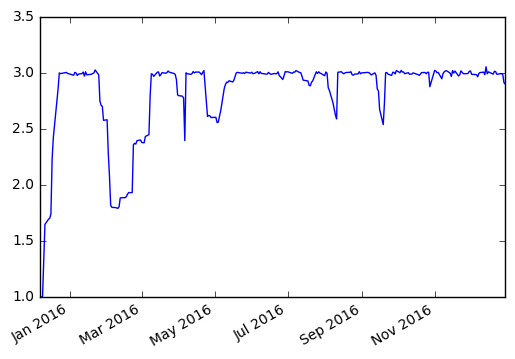

In [119]:
res.leverage.plot()

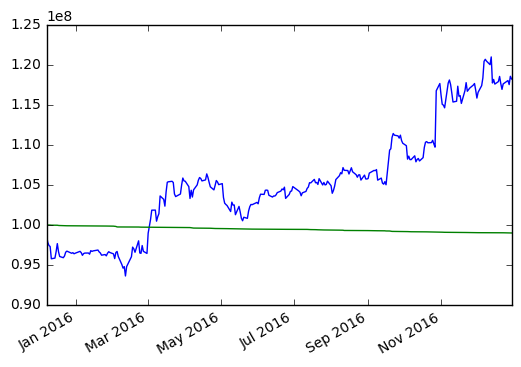

In [120]:
res.v.plot()
(res.initial_val-res.simulator_TcostModel.sum(1).cumsum()).plot()

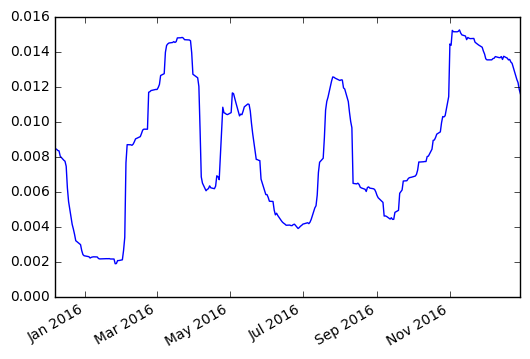

In [121]:
np.sqrt(res.policy_EmpSigma).plot()

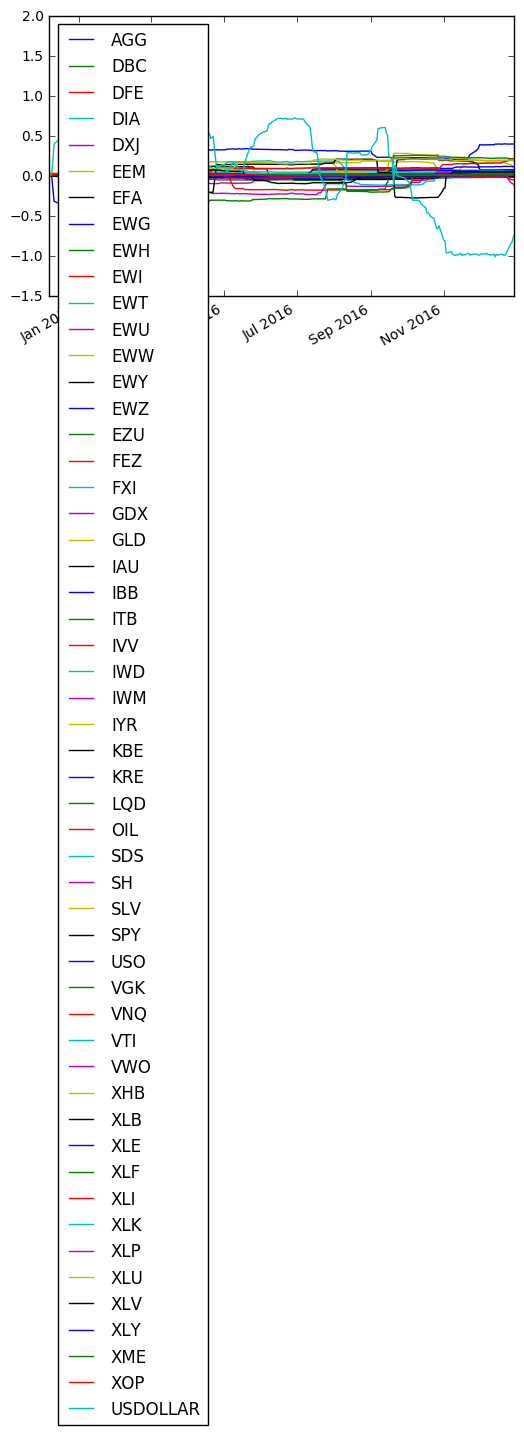

In [122]:
res.w.plot()

## Results 

In [ ]:
res._data['policy.EmpSigma'].AGG.plot()

In [ ]:
res.w.plot()

In [ ]:
pandl = lambda res: 100*(res.v[-1]-res.initial_val)/res.initial_val
tcosts = lambda res: 100*res._data['simulation.TcostModel'].sum().sum()/res.initial_val
tmp=pd.Panel({'P&L':res.applymap(pandl), 'TCosts':res.applymap(tcosts)})
result_df = tmp.swapaxes(0,1).swapaxes(1,2).to_frame().T
result_df

In [ ]:
print(result_df.to_latex(float_format='%.2f%%'))

# Plots 

In [ ]:
offsetx = .12
offsety = .13

for ticker, values in result_df.iterrows():
    for size, coord in values.unstack().iterrows():
        x,y=coord['TCosts'],coord['P&L']
        if size=='$100M':
            line1,=plt.plot(x,y, 'ko', markersize=11, fillstyle='none', label='100M fund')
            plt.text(x-offsetx,y-offsety, ticker)

        if size=='$10B':
            line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='10B fund')
            plt.text(x-offsetx,y-offsety,ticker,color='r' )

plt.xlim([-1, 10])
plt.ylim([13, 25])
plt.legend(loc='upper right',handles=[line1, line2])
plt.xlabel("Simulated TCosts (%)")
plt.ylabel("Simulated P&L (%)")
plt.title("1/n portfolio rebalancing (2007-2016)")

plt.savefig(plotdir+'pandl_vs_tcost.png')

In [ ]:
for k,results in res.loc['D'].iteritems():
    plt.figure()
    (100*(results.v-results.initial_val)/results.initial_val).plot(label='P&L (%)')
    (100*(-results._data['simulation.TcostModel'].sum(1).cumsum())/results.initial_val).plot(style='r',label='cum. TCosts (%)')
    plt.legend(loc='lower right')
    plt.title('%s 1/n portfolio daily rebalance'%k)
    plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])